# Necessary Library

In [851]:
import pandas as pd
from sklearn.impute import KNNImputer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display

# 0. Upload data

In [852]:
data = pd.read_csv('../../data/data.csv')

# 1. Understand your data

## Display head of Data

In [853]:
data.head()

,Unnamed: 0,name,model,price,color,fuel_type,origin_car,car_license,lime_type,glass,...,payment_method,displayed,ex_owners,additional_info,insurance_third,supplementary_body,total,ads_status,ads_start_data,ads_end_data
0,0,كيا اوبتيما,2014,100000,أبيض عاجي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,...,نقدا فقط,للبيع فقط,يد اولى,"مُكيّف,إغلاق مركزي,جهاز إنذار,مسجل CD,فتحة سقف...",1340.0,1751.0,3090.0,منتهي,2017-08-16,2017-09-15
1,1,كيا سورينتو,2007,60000,سكني,ديزل,خصوصي,فلسطينية,نصف اوتوماتيك,الكتروني,...,إمكانية التقسيط,للبيع أو التبديل,2,"مُكيّف,إغلاق مركزي,جهاز إنذار,مسجل CD,فتحة سقف...",1690.0,1050.0,2740.0,منتهي,2017-08-16,2017-09-30
2,2,هونداي افانتي,2006,43500,سكني,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,...,نقدا فقط,للبيع فقط,NaN,"مُكيّف,إغلاق مركزي,جهاز إنذار,مسجل CD,جنطات مغ...",1340.0,1000.0,2340.0,منتهي,2017-08-19,2017-09-18
3,3,فيات 127,1982,5500,بيج,بنزين,خصوصي,فلسطينية,عادي,يدوي,...,إمكانية التقسيط,للبيع فقط,00,"مُكيّف,مسجل CD",467.0,500.0,967.0,منتهي,2017-08-17,2017-09-22
4,4,بيجو 208,2014,54000,فضي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,...,نقدا فقط,للبيع فقط,NaN,"مُكيّف,إغلاق مركزي,جهاز إنذار,جنطات مغنيسيوم,و...",1035.0,1000.0,2035.0,منتهي,2017-08-17,2017-10-01


- We have an Unnamed ID that we can delete
- Most of the columns are categorical

In [854]:
data.columns

Index(['Unnamed: 0', 'name', 'model', 'price', 'color', 'fuel_type',
       'origin_car', 'car_license', 'lime_type', 'glass', 'motor_power',
       'car_speedometer', 'passengers', 'payment_method', 'displayed',
       'ex_owners', 'additional_info', 'insurance_third', 'supplementary_body',
       'total', 'ads_status', 'ads_start_data', 'ads_end_data'],
      dtype='object')

## Shape of data

In [855]:
data.shape

(6161, 23)

## Decribe data

In [856]:
# Category features
data.describe(include='O')

,name,color,fuel_type,origin_car,car_license,lime_type,glass,car_speedometer,passengers,payment_method,displayed,ex_owners,additional_info,ads_status,ads_start_data,ads_end_data
count,6161,6161,6161,6161,6161,6161,6161,4380,5447,6161,6161,4661,5715,6161,6161,6161
unique,596,26,3,6,2,3,2,1200,43,2,3,339,191,1,1442,1597
top,سكودا اوكتافيا,أبيض,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,100000,4+1,نقدا فقط,للبيع فقط,يد اولى,"مُكيّف,إغلاق مركزي,جهاز إنذار,مسجل CD,جنطات مغ...",منتهي,2019-09-28,2019-10-28
freq,446,1292,3594,5211,6090,3195,5662,90,4344,3863,3771,452,1100,6161,14,13


- We have 596 different automobile models, with the Skoda Octavia being the most popular.

- Car License, Origin Car, Glass, their unique value was replicated 6090 out of 6161, and it appears that it will be useless.

- Because the advertisements status has a unit value, it is useless.

In [857]:
# Numerical features
data.describe()

,Unnamed: 0,model,price,motor_power,insurance_third,supplementary_body,total
count,6161.000000,6161.000000,6161.000000,6161.000000,6152.000000,6152.000000,6152.000000
mean,3080.000000,2008.229021,65293.567603,1740.785100,1148.600618,1244.490897,2392.950910
std,1778.671836,8.752494,56326.044654,589.016536,313.160799,899.502486,1080.223525
min,0.000000,1967.000000,1200.000000,106.000000,467.000000,500.000000,967.000000
25%,1540.000000,2005.000000,35000.000000,1400.000000,1035.000000,1000.000000,2035.000000
50%,3080.000000,2010.000000,54500.000000,1600.000000,1340.000000,1000.000000,2340.000000
75%,4620.000000,2015.000000,80000.000000,2000.000000,1340.000000,1401.000000,2740.000000
max,6160.000000,2021.000000,999999.000000,9000.000000,1690.000000,17500.000000,18535.000000


- Model is a category because it is a year, not a number.
- Insurance Third has skewed left
- Total and motor power feel normal
- Price has skewed right

## Basic Information

In [858]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6161 entries, 0 to 6160
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          6161 non-null   int64  
 1   name                6161 non-null   object 
 2   model               6161 non-null   int64  
 3   price               6161 non-null   int64  
 4   color               6161 non-null   object 
 5   fuel_type           6161 non-null   object 
 6   origin_car          6161 non-null   object 
 7   car_license         6161 non-null   object 
 8   lime_type           6161 non-null   object 
 9   glass               6161 non-null   object 
 10  motor_power         6161 non-null   int64  
 11  car_speedometer     4380 non-null   object 
 12  passengers          5447 non-null   object 
 13  payment_method      6161 non-null   object 
 14  displayed           6161 non-null   object 
 15  ex_owners           4661 non-null   object 
 16  additi

- We have 3 types of data (object, number and float)
- There are some missing values

# Handle Some Data Columns

### Handle Passengers Column

In [859]:
passengers:list = []

for row in data['passengers']:
    sum_digit = 0
    if pd.isna(row):
        passengers.append(np.NaN)
        continue
    for char in str(row):
        if char.isdigit():
            int_char = int(char)
            sum_digit = sum_digit + int_char
    passengers.append(sum_digit)

data['passengers'] = pd.Series(passengers).copy()
data['passengers'].unique()

array([ 5.,  8., nan,  6.,  7.,  3.,  1.,  4.,  2.,  9.,  0., 10.])

### Handle ex_owner Column 

In [860]:
data['ex_owners'].unique()

array(['يد اولى ', '2 ', nan, '00  ', '0 ', '1 ', 'يد ثانية ', '4 ',
       'يد ثانيه ', '3 ', 'ثالثة ', 'غير منمر استيراد الماني ', '00 ',
       'غير منمرة ', 'أولى ', '٨ ', 'يد اولا ', 'يد ثالثة ', 'يد ثالثة  ',
       'ثانية ', 'يد أولى ', 'يد سادسة ', '5 ', 'اولى  ', 'صفر ', '9 ',
       '0000 ', 'رابعه ', 'يد أولى  ', '٤ ', 'يد رابعة  ', '٢ ',
       'يد ثالثه ', '6 ', 'يد اولى  ', '7 ', '... ', 'يد ثانيه  ',
       'يد أولى استيراد ', 'يد اولي 1 ', 'اولى ', '...... ', 'ثانيه ',
       'واحد ', 'اربعة ', 'اولا ', '٣ ', 'غير منمره ', 'يد تالته ', '٦ ',
       'يد رابعه ', 'يد ثالثة ( فتيات) ', '159000 ', '12 ', '- ',
       'مش منمر ', '0 مستورده ', 'يد تانيه ', '10 ', 'يد 1 ', 'مستورد ',
       'يد 4 ', 'يد رابعة ', '00000 ', '١ ', 'استيراد مباشر من كوريا  ',
       'يد خامسة ', '٥ ', 'يد 5 ', '******** ', 'نعم ', 'مش منمرة  ',
       'يد 3 ', ' يد ثانيه ', 'يداولى ', '4  ', 'يد أولى وكالة ',
       'يد خامسه ', 'يد ثانية  ', '٩ ', '٧ ', 'يدو اولى ', 'للبيع  ',
       '8 ', 'يد و

In [861]:
ex_owner:dict = {
    'Nan_numaric': [np.NaN, '78888877766', '159000', '170000', '123423', '12345', '1000', '11111', '778244', '١٨', '١١', '١٢', '١٥', '١٧'],
    'Nan_value' : [np.NaN, '\x89', '.','*' , '@', '؟', '-' ,'،', '?', 'اشخاص', 'مس', 'شطب', 'E', 'مشطوب', 'خصوصي', 'للبيع', 'نعم', 'منمره'],
    'zero': ['0', '٠', 'صفر', 'صفرض', 'صفرر', 'لا شيء ','Zero','O', 'Ooo', '0',   'غير مرخصة', 'سحب', 'اصل',
             'مستورد', 'استيراد', 'مستوردة', 'استراد', 'مستورده', 'وارد', 'استراد', 'أستيراد' ],
    'ones' : ['1', 'أولى', 'اولى', 'اولا', 'واحد', 'اول', 'ياولى', 'اوله', 'انا','اولي', 'واله', 'ولا', 'واحدة', 'أولئ', 'ولى',
              'أولي', 'اولئ', 'اولة', 'اةلي', '١'],
    'ones_numra':['1', 'غير منمرة', 'مش', 'لا يوجد', 'لايوجد','غير','لا يوجد', 'يد ا', 'ا' , 'يد'],
    'two' : ['2', 'تانيه', 'ثني', 'تاني', 'ثاتيه', 'تانية', 'ثاني', 'ثانبه', 'تانبه', 'ثانيا', 'يانيه', 'ثانية', 'ثانيه', 'اثنان', '٢'],
    'three' : ['3', 'ثالثة', 'ثالثه', 'تالثه', 'تالته', 'ثالث', 'التالته', '٣'],
    'four'  : ['4', 'اربعه', 'رابعه', 'اربعة', 'رابعة','٤'],
    'five'  : ['5', 'خامسة', 'خامسه', 'خامساً', 'خمسة', 'خمسه', '٥'],
    'six'   : ['6', 'سادسة', '٦'],
    'seven' : ['7', 'سابعة', 'سابعه', '٧'],
    'eight' : ['8', 'ثامنه', 'ثمانيه', '٨'],
    'nighn' : ['9', 'تاسعة', '٩'],
    'ten'   : ['10', 'عاشره', '١٠']
   
}

In [862]:
def handle_ex_owner(search_list):
    index = []
    for search_word in search_list:
        search_word = str(search_word)
        count = 0
        for item in data['ex_owners']:
            item = str(item)
            split_item = item.split(' ')
            for i in range(len(split_item)):
                if search_word in split_item[i]:
                    index.append(count)
            count += 1
    return index

for key in ex_owner.keys():
   data['ex_owners'].iloc[handle_ex_owner(ex_owner[key])] = float(ex_owner[key][0])

data['ex_owners'].unique()

C:\Users\DELL\AppData\Local\Temp\ipykernel_6376\3710021957.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ex_owners'].iloc[handle_ex_owner(ex_owner[key])] = float(ex_owner[key][0])


array([1.0, 2.0, nan, 0.0, 4.0, 3.0, 8.0, 5.0, 9.0, 6.0, 7.0],
      dtype=object)

### Handle car_speedometer Column

In [863]:
index = 0
for item in data['car_speedometer']:
    item = str(item).split(' ')
    for i in range(len(item)): 
        if item[i].isdigit():
            data['car_speedometer'].iloc[index] = item[i]
            break
        if i == len(item)-1:
            data['car_speedometer'].iloc[index] = np.NaN
    index += 1

data['car_speedometer'].unique()

C:\Users\DELL\AppData\Local\Temp\ipykernel_6376\1888983739.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['car_speedometer'].iloc[index] = item[i]
C:\Users\DELL\AppData\Local\Temp\ipykernel_6376\1888983739.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['car_speedometer'].iloc[index] = np.NaN


array(['75000', '130000', nan, '38000', '١٢٣٤٥٦', '50000', '56000',
       '460000', '45000', '70000', '79000', '000', '150', '210000', '1',
       '20000', '00000000000000000', '113000', '33000', '00000000000000',
       '22000', '150000', '29000', '123457', '٢٥٠٠٠٠', '140000', '122000',
       '78000', '00000', '900000', '7', '00000000', '65000', '190',
       '184000', '200', '30000', '295000', '60000', '143212', '43000',
       '71', '160000', '4000', '121000', '9900', '٢٦٠', '0000', '80',
       '200000', '60', '124000', '100000', '90000', '000000', '99',
       '82000', '32123123', '120', '166000', '275000', '82700', '123000',
       '120000', '500000', '18000000', '١٥٠', '80000', '87000', '110000',
       '350000', '700000', '55', '٤٠٠٠٠٠', '35000', '380000', '167000',
       '140', '160', '123456789', '111111', '94000', '90', '46000', '82',
       '51', '280000', '115', '300000', '٤١٠٠٠', '196000', '274000',
       '١٢٠٠٠٠', '2000', '٠٠٠٠٠', '136000', '116000', '13700', '132',


### Handle date columns

In [864]:
for feature in ['ads_start_data', 'ads_end_data']:
    data[feature] = pd.to_datetime(data[feature])

## Duplicates

In [865]:
#Find the duplicates
data.duplicated().sum()

0

thers no duplicates values

## Data type for data

In [866]:
data.dtypes

Unnamed: 0                     int64
name                          object
model                          int64
price                          int64
color                         object
fuel_type                     object
origin_car                    object
car_license                   object
lime_type                     object
glass                         object
motor_power                    int64
car_speedometer               object
passengers                   float64
payment_method                object
displayed                     object
ex_owners                     object
additional_info               object
insurance_third              float64
supplementary_body           float64
total                        float64
ads_status                    object
ads_start_data        datetime64[ns]
ads_end_data          datetime64[ns]
dtype: object

# 2. Preparation and transformation

## Handle missing values

In [867]:
missing_value_columns = data[data.columns[data.isna().sum() > 0]].isna().sum()
missing_value_columns

car_speedometer       1915
passengers             714
ex_owners             1632
additional_info        446
insurance_third          9
supplementary_body       9
total                    9
dtype: int64

In [868]:
data['additional_info'].fillna("No additional value", inplace=True)

In [869]:
missing_value_columns = data[data.columns[data.isna().sum() > 0]].isna().sum()
missing_value_columns 

car_speedometer       1915
passengers             714
ex_owners             1632
insurance_third          9
supplementary_body       9
total                    9
dtype: int64

### I can use knn for fill missing of numeric columns

In [870]:
# define imputer
imputer = KNNImputer(n_neighbors=3, weights='uniform', metric='nan_euclidean')

# fit on the dataset
imputer.fit(data[missing_value_columns.index])

# transform the dataset
data[missing_value_columns.index] = imputer.transform(data[missing_value_columns.index])

In [871]:
data[missing_value_columns.index].isna().sum()

car_speedometer       0
passengers            0
ex_owners             0
insurance_third       0
supplementary_body    0
total                 0
dtype: int64

## Drop useless columns

In [872]:
# Delete the Unnamed ID column
data.drop(columns="Unnamed: 0", inplace=True)

### Display Correlations between Numaric Features

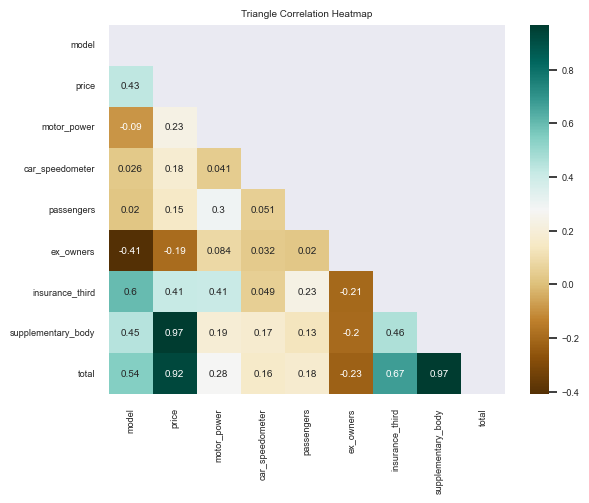

In [873]:
# Display the correlation between all features
mask = np.triu(np.ones_like(data.select_dtypes(include='number').corr()))
heatmap = sns.heatmap(data.select_dtypes(include='number').corr(), mask=mask,  annot=True, cmap='BrBG').set_title('Triangle Correlation Heatmap');

supplementary_body and total -> 0.97 : High Positive Corelation

supplementary_body and price -> 0.97 : High Positive Corelation

price and total              -> 0.92 : High Positive Corelation

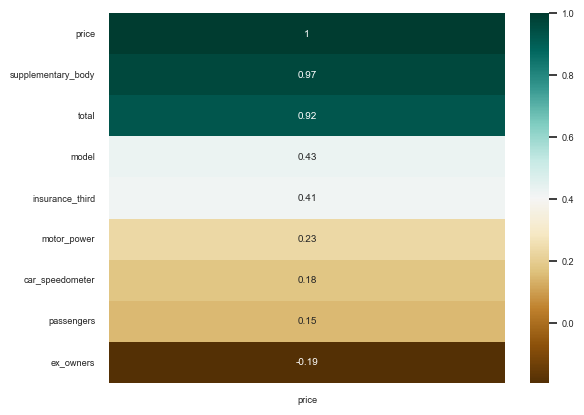

In [874]:
# Display the correlation between target variable (price) with all other numaric features 
heatmap = sns.heatmap(data.select_dtypes(include='number').corr()[['price']].sort_values(by='price', ascending=False), annot=True, cmap='BrBG')

supplementary_body has high corelated with price (target) so I had to grip it tightly.

And because supplementary body is so closely related to total, I'm skipping the total.

In [875]:
# Delete the total Column
data.drop('total', axis=1, inplace=True)
# Check Deletion
data.columns

Index(['name', 'model', 'price', 'color', 'fuel_type', 'origin_car',
       'car_license', 'lime_type', 'glass', 'motor_power', 'car_speedometer',
       'passengers', 'payment_method', 'displayed', 'ex_owners',
       'additional_info', 'insurance_third', 'supplementary_body',
       'ads_status', 'ads_start_data', 'ads_end_data'],
      dtype='object')

## Rename columns 

In [876]:
# Dictionary contains the previous name column and what I want the column name set to
feature_rename = {
    'origin_car':'car_type',
    'car_license': 'license_type',
    'glass': 'glass_type',
    'displayed': 'display_purpose',
    'supplementary_body': 'insurance_supplementary',
    'ads_start_data': 'ads_start_date',
    'ads_end_data': 'ads_end_date'
}

# Rename specific columns based on the feature_name dictionary
data.rename(columns=feature_rename, inplace=True)

# Display the columns after rename 
data.columns

Index(['name', 'model', 'price', 'color', 'fuel_type', 'car_type',
       'license_type', 'lime_type', 'glass_type', 'motor_power',
       'car_speedometer', 'passengers', 'payment_method', 'display_purpose',
       'ex_owners', 'additional_info', 'insurance_third',
       'insurance_supplementary', 'ads_status', 'ads_start_date',
       'ads_end_date'],
      dtype='object')

## create new features

# 3. Univariate analysis

Iterate through each and every relevant variable and get basic information such as

This is the first step of outlier detection. Here's is where you get up and personal with each variable

## Histograms

In [878]:
display_data = data.copy()
for feature in display_data.select_dtypes(include='object').columns:
    temp = []
    for row in display_data[feature]:
        temp.append(get_display(arabic_reshaper.reshape(row)))
    temp = pd.Series(temp)
    display_data[feature] = temp

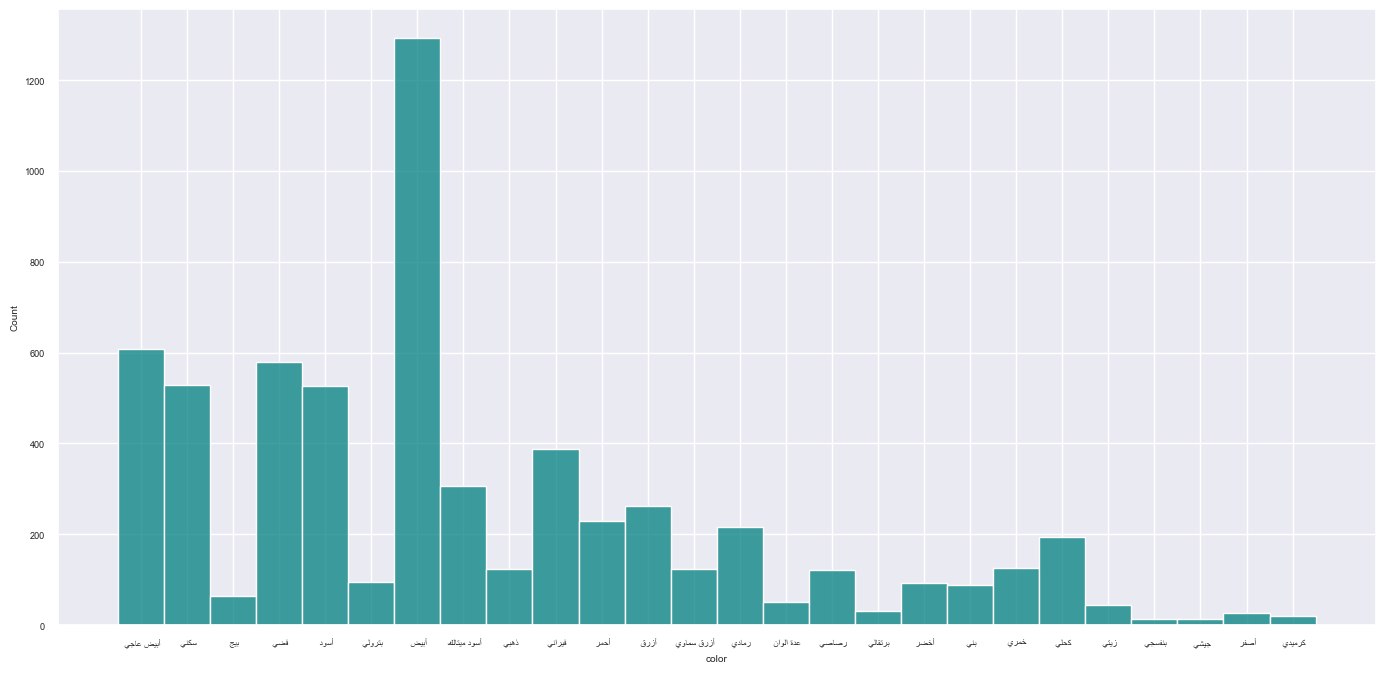

In [879]:
plt.subplots(figsize=(17, 8))
sns.histplot(data=display_data, x="color", color="teal");

I will not use One Hot Encoding for this feature since it is nonsensical for me to divide it into multiple features, each of which is significant but not critical.

I will do a mapping between the color name and a number for it

In [880]:
# Create metadata dictionary for category information
# Its primary objective is to store numbers and the text values 
# that they represent in category features.
category_metadata = {}

# Get the codes with its for color category
category_metadata['color'] = dict(enumerate(data['color'].astype('category').cat.categories))

# Get the codes for color category
data['color'] = data['color'].astype('category').cat.codes

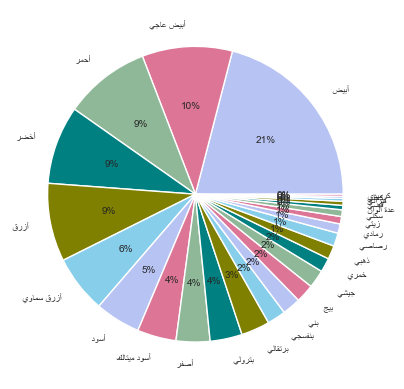

In [881]:
# Display color column after converting
temp = []
for item in list(category_metadata['color'].values()):
    temp.append(get_display(arabic_reshaper.reshape(item)))

plt.pie(data['color'].value_counts(), labels=temp, labeldistance=1.15, autopct='%.0f%%', \
    wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=['#B7C3F3', '#DD7596', '#8EB897', 'teal', "olive", "skyblue"]);

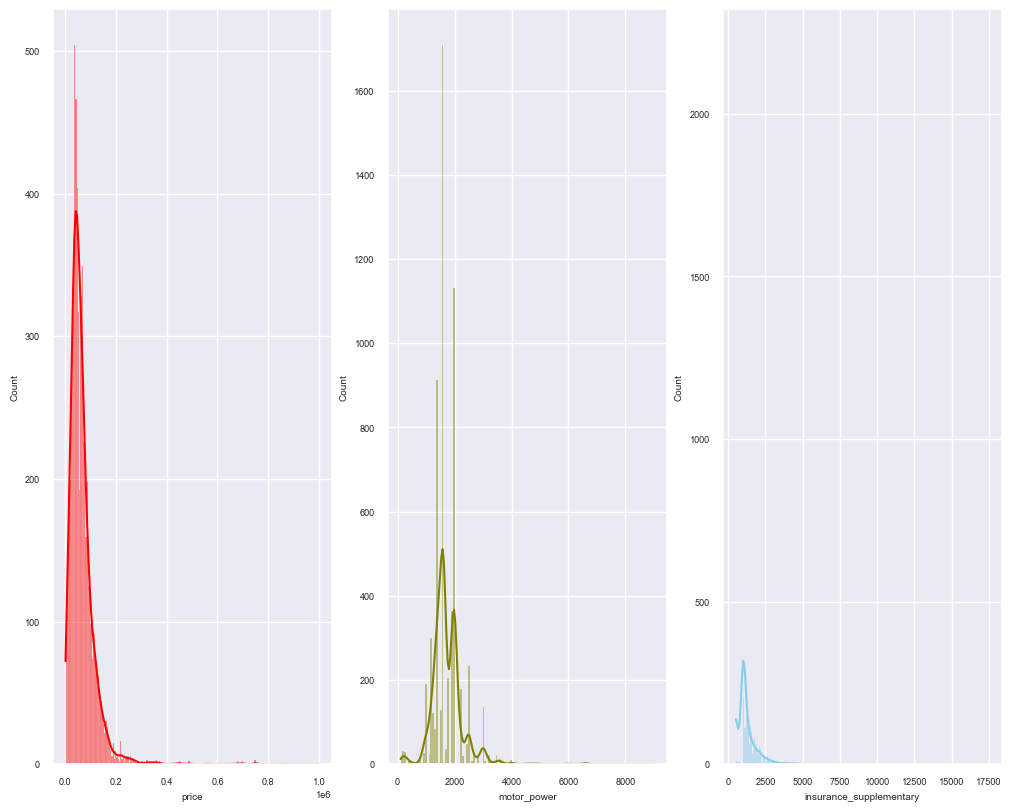

In [923]:
fig, axs = plt.subplots(1, 3, figsize=(10, 8), constrained_layout = True)

sns.histplot(data=display_data, x="price", kde=True, color="red", ax=axs[0])
sns.histplot(data=display_data, x="motor_power", kde=True, color="olive", ax=axs[1])
sns.histplot(data=display_data, x="insurance_supplementary", kde=True, color="skyblue", ax=axs[2]);

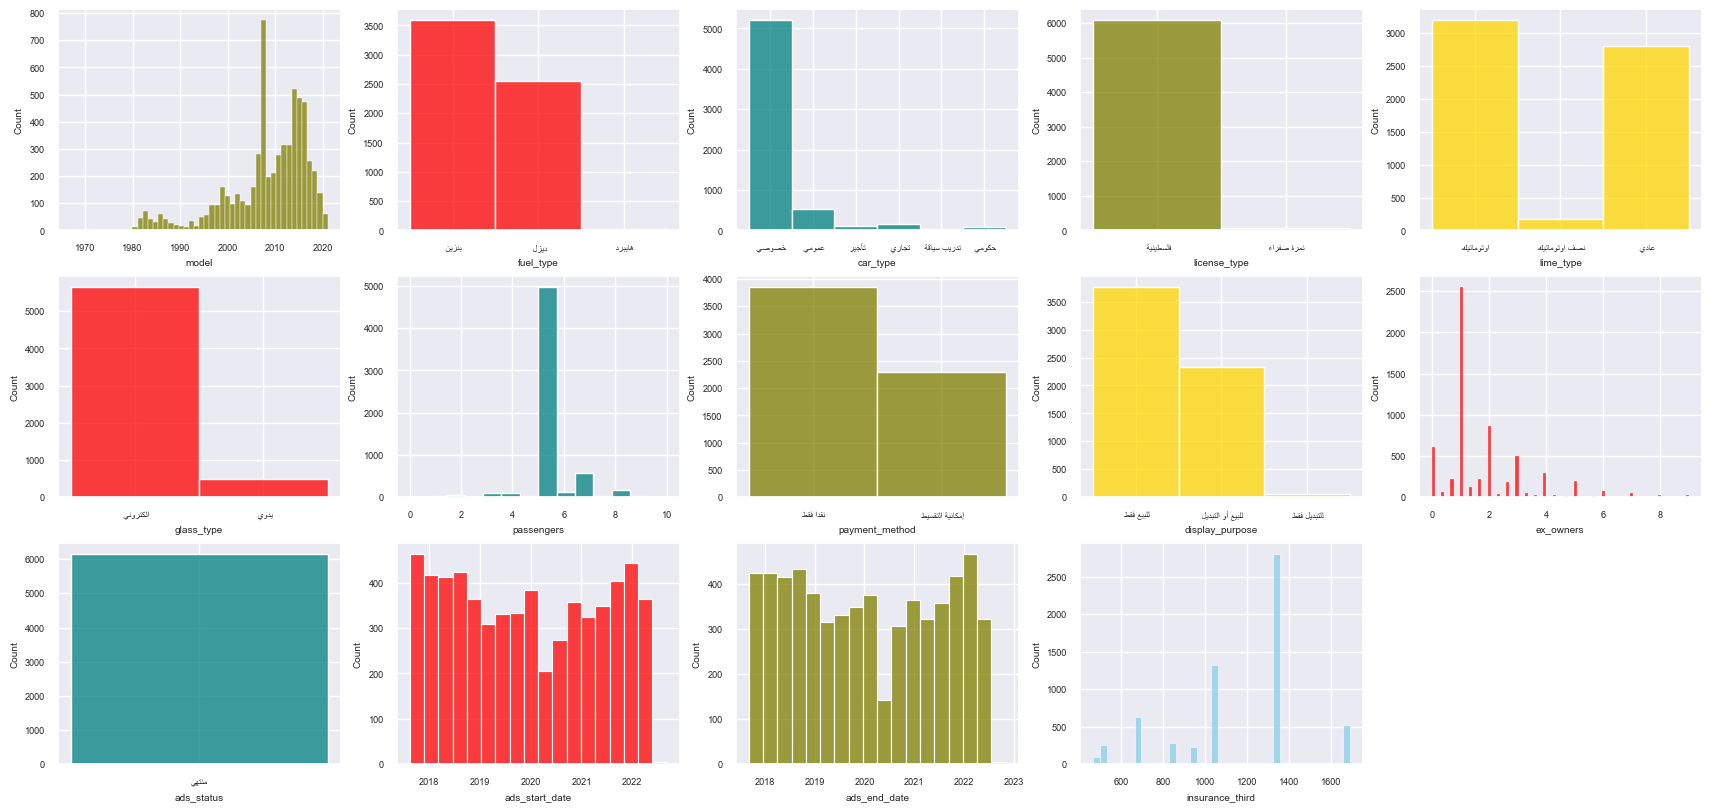

In [928]:
fig, axs = plt.subplots(3, 5, figsize=(17, 8), constrained_layout = True)

sns.histplot(data=display_data, x="model", color="olive", ax=axs[0, 0])
sns.histplot(data=display_data, x="fuel_type", color="red", ax=axs[0, 1])
sns.histplot(data=display_data, x="car_type", color="teal", ax=axs[0, 2])
sns.histplot(data=display_data, x="license_type", color="olive", ax=axs[0, 3])
sns.histplot(data=display_data, x="lime_type", color="gold", ax=axs[0, 4])

sns.histplot(data=display_data, x="glass_type", color="red", ax=axs[1, 0])
sns.histplot(data=display_data, x="passengers", color="teal", ax=axs[1, 1])
sns.histplot(data=display_data, x="payment_method", color="olive", ax=axs[1,2])
sns.histplot(data=display_data, x="display_purpose", color="gold", ax=axs[1,3])
sns.histplot(data=display_data, x="ex_owners", color="red", ax=axs[1,4])

sns.histplot(data=display_data, x="ads_status", color="teal", ax=axs[2,0])
sns.histplot(data=display_data, x="ads_start_date", color="red", ax=axs[2,1])
sns.histplot(data=display_data, x="ads_end_date", color="olive", ax=axs[2,2])
sns.histplot(data=display_data, x="insurance_third", color="skyblue", ax=axs[2,3]);

fig.delaxes(axs[2,4])

## value counts

## Skew

## Kurt

# 4. Multivariate analysis

Now you use seaborn to do scatterplots and pairplots

the first allow you to plot 2 variables against each other and understand how they move together.

Pairplots do this for all variables, all at the same time.

Play with the hue parameter in sns